# Assignment 2

Erik Strand
13 October 2020

### Research Question

Who are the most frequent repeat callers to the 311 line? Where are they, what kinds of calls are they making, and how do their calls vary over time? 

#### Scope

I will be looking at the entire 10-year period to find the top few addresses from which the most 311 calls originated.

In [1]:
# import required packages 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from urllib.parse import urlencode
import urllib.request, json
from plotnine import * # I prefer this plotting library as it's more familiar to me

In [2]:
# API key for the 311 dataset
API = "https://data.cityofnewyork.us/resource/erm2-nwe9.csv?"

# A quick query to see how many *total* calls were placed to 311 in this time period
query = {'$select': 'count(*) as total_counts'}

df = pd.read_csv(API + urlencode(query))
df.head()

,total_counts
0,24130631


In [3]:
# Second API query. I'm retrieving the total counts of complaints submitted by adddress since 2010.
query1 = {'$select': 'incident_address, count(*) as total_counts',
         '$group': 'incident_address',
         '$order': 'total_counts DESC',
         '$limit': 100000
         }

df1 = pd.read_csv(API + urlencode(query1))
df1.head(10)

,incident_address,total_counts
0,NaN,4282947
1,655 EAST 230 STREET,32561
2,89-21 ELMHURST AVENUE,16316
3,672 EAST 231 STREET,15709
4,34 ARDEN STREET,14561
5,78-15 PARSONS BOULEVARD,13873
6,BROADWAY,13332
7,1025 BOYNTON AVENUE,12703
8,674 EAST 231 STREET,9981
9,82-16 164 STREET,8136


This first selection gives us addresses in NYC which called 311 a *lot* of times since 2010. Let's do some further exploration: 

In [4]:
print(df1["incident_address"].nunique())
print(df1["total_counts"].max())
print(df1["total_counts"].min())

99999
4282947
32


As expected, we pulled data for 99,999 addresses in NYC. The address with the most calls made over 4.2 million calls over the past 10 years; the address with the least made just 32. VIS HERE This is still a really huge range, so my next step is to filter it down some. 

Next, let's make a more filtered version of this data that just looks at addresses which made more than 1,000 311 calls. (This is an arbitrary number, but feels like a good break point to try.)

In [5]:
repeat_callers = df1.query("total_counts > 1000")
print(repeat_callers["incident_address"].nunique())
top = repeat_callers.head(102)
top = top.drop([0, 6])
top

926


,incident_address,total_counts
1,655 EAST 230 STREET,32561
2,89-21 ELMHURST AVENUE,16316
3,672 EAST 231 STREET,15709
4,34 ARDEN STREET,14561
5,78-15 PARSONS BOULEVARD,13873
...,...,...
97,2251 HOLLAND AVENUE,2574
98,644 RIVERSIDE DRIVE,2563
99,LEXINGTON AVENUE,2554
100,ATLANTIC AVENUE,2547


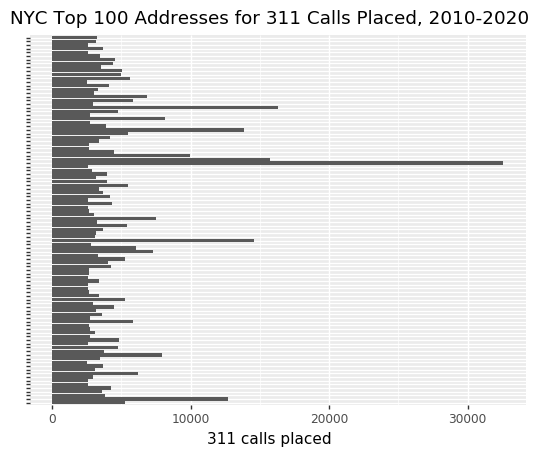

<ggplot: (8774546995421)>

In [6]:
ggplot(top, aes(x = "incident_address", y = "total_counts")) + geom_col() + coord_flip() + xlab("") + scale_x_discrete(labels = "") + ylab("311 calls placed") + ggtitle("NYC Top 100 Addresses for 311 Calls Placed, 2010-2020")

We now have just 926 addresses that made at least 1,000 calls since 2010. Some of these are obviously not real addresses: our top offender is the 'NA' designation, and we also see 'Broadway' in our top 10, which is a very long street and obviously doesn't designate an address. However, the other eight addresses here appear to be real street addresses, so we have some good data to work with. 

Next, I decided to focus on addresses that placed more than 10,000 calls. I want to try to figure out what these buildings are calling about and how those trends have changed over time. 

For my next API call, I'll pull all call records for this address in order to analyze trends a bit further. 

In [7]:
query2 = {'$select': 'incident_address, complaint_type, date_trunc_ym(created_date) as ym, count(*) as total_counts',
         '$where': 'incident_address="655 EAST  230 STREET" or incident_address="89-21 ELMHURST AVENUE" or incident_address="672 EAST  231 STREET" or incident_address="34 ARDEN STREET" or incident_address="78-15 PARSONS BOULEVARD" or incident_address="1025 BOYNTON AVENUE"',
         '$group': 'incident_address, complaint_type, ym',
         '$order': 'total_counts DESC',
         '$limit': 100000
         }

top_caller = pd.read_csv(API + urlencode(query2),
                         parse_dates = ['ym'])

print(top_caller["total_counts"].sum())
top_caller.head(10)

105723


,incident_address,complaint_type,ym,total_counts
0,655 EAST 230 STREET,Noise - Residential,2020-08-01,11813
1,655 EAST 230 STREET,Noise - Residential,2020-09-01,8091
2,672 EAST 231 STREET,Noise - Residential,2020-06-01,5321
3,655 EAST 230 STREET,Noise - Residential,2020-07-01,4912
4,655 EAST 230 STREET,Noise - Residential,2020-10-01,4377
5,672 EAST 231 STREET,Noise - Residential,2020-07-01,4224
6,672 EAST 231 STREET,Noise - Residential,2020-05-01,3999
7,655 EAST 230 STREET,Noise - Residential,2020-04-01,2121
8,655 EAST 230 STREET,Noise - Residential,2020-05-01,1172
9,672 EAST 231 STREET,Noise - Residential,2020-09-01,1162


In [8]:
print(top_caller.groupby("complaint_type")["total_counts"].sum().sort_values(ascending=False).head(10))

print(top_caller.groupby("ym")["total_counts"].sum().sort_values(ascending=False).head(10))

print(top_caller.groupby(["complaint_type", "ym"])["total_counts"].sum().sort_values(ascending=False).head(10))

complaint_type
Noise - Residential            50271
HEAT/HOT WATER                 22006
HEATING                        10110
Illegal Parking                 5248
Noise - Vehicle                 4750
UNSANITARY CONDITION            2593
Non-Emergency Police Matter     2042
Noise                           1930
Noise - Street/Sidewalk         1054
DOOR/WINDOW                      633
Name: total_counts, dtype: int64
ym
2020-08-01    13089
2020-09-01    11020
2020-07-01     9648
2020-06-01     5855
2020-05-01     5553
2020-10-01     4580
2020-04-01     2468
2019-03-01     1769
2019-02-01     1572
2016-02-01     1272
Name: total_counts, dtype: int64
complaint_type       ym        
Noise - Residential  2020-08-01    12468
                     2020-09-01     9258
                     2020-07-01     9141
                     2020-06-01     5340
                     2020-05-01     5173
                     2020-10-01     4378
                     2020-04-01     2124
HEAT/HOT WATER       2016-0

Overall, we can see that the vast majority of the calls placed by these six buildings were either 1) noise complaints, 2) heat/hot water  complaints, or 3) other heating complaints. 

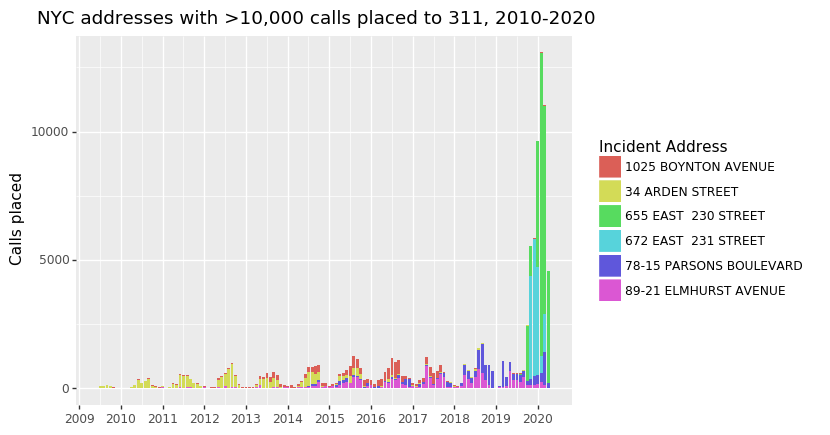

<ggplot: (8774548789709)>

In [9]:
ggplot(top_caller, aes(x = 'ym', y = 'total_counts', fill = "incident_address")) + geom_col(position = "stack") + ggtitle("NYC addresses with >10,000 calls placed to 311, 2010-2020") + xlab("") + ylab("Calls placed") + scale_x_date(date_breaks = "12 months", date_labels = "%Y") + scale_fill_discrete(name = "Incident Address")